https://github.com/SSinyu/RED-CNN

#### 패키지 업로드 및 시드 설정

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data 
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import glob

# 코드 실행결과의 동일성을 위해 무작위 시드를 설정합니다
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 만일 새로운 결과를 원한다면 주석을 없애면 됩니다
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Random Seed:  999


In [2]:
!nvidia-smi

Tue Sep 27 11:46:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   48C    P8    32W / 370W |      2MiB / 24259MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
os.getcwd()

'/home/user303/3_jihyeheo/GAN/DCGAN'

#### 파라미터 설정

In [4]:
# 데이터셋의 경로
path = '/home/user303/GAN/COVID-19_Radiography_Dataset/Normal/images'
image_paths = glob.glob(path + '/*.png')
image_paths = sorted(image_paths)

# dataloader에서 사용할 쓰레드 수
workers = 0

# 배치 크기
batch_size =16

# 이미지의 크기입니다. 모든 이미지들은 transformer를 이용해 64로 크기가 통일됩니다.
image_size = 64

# 이미지의 채널 수로, RGB 이미지이기 때문에 3으로 설정합니다.
nc = 1
ngf = 64
ndf = 64
nz = 64
# 옵티마이저의 학습률
lr = 0.0002

# Adam 옵티마이저의 beta1 하이퍼파라미터
beta1 = 0.5

# 사용가능한 gpu 번호. CPU를 사용해야 하는경우 0으로 설정하세요
ngpu = 1

#### 데이터 불러오기 및 DataLoader 정의

In [5]:
transform=transforms.Compose([
                               transforms.ToPILImage(),
                               transforms.Resize(image_size),
                               #transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5), (0.5)),
                           ])

In [6]:
import cv2
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, index):
        image_path = self.paths[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
        
        if self.transform:
            image_tensor = self.transform(image)
            
        return image_tensor
    
train_dataset = ImageDataset(image_paths[:round(len(image_paths)*0.8)], transform)
test_dataset = ImageDataset(image_paths[round(len(image_paths)*0.8):], transform)

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

# GPU 사용여부를 결정해 줍니다
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

#### 모형 정의

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
                    # 100x1 z 1D vector에서 2D vector로의 변환이 없는 이유: 애초에 z random sampling 시 1x1 matrix 형태로 sampling 하면 됨.
                    # out_channels은 특징이 추출된 image의 수?라고 봐야할 듯
            nn.ConvTranspose2d(in_channels=nc,
                                       out_channels=ngf*2,
                                       kernel_size=4, 
                                       stride=2,
                                       padding=1, 
                                       bias=False),
                    nn.BatchNorm2d(ngf*2),
                    nn.ReLU(True),
             nn.ConvTranspose2d(in_channels=ngf*2,
                                       out_channels=ngf,
                                       kernel_size=4, 
                                       stride=2,
                                       padding=1,
                                       bias=False),
                    nn.BatchNorm2d(ngf),
                    nn.ReLU(True),
#             nn.ConvTranspose2d(in_channels=ngf,
#                                        out_channels=ngf//2,
#                                        kernel_size=4, 
#                                        stride=4,
#                                        padding=1,
#                                        bias=False),
#                     nn.BatchNorm2d(ngf//2),
#                     nn.ReLU(True), 
            
            
            nn.Conv2d(ndf,
                      ndf//4,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(ndf//4),
            nn.LeakyReLU(0.2, inplace=True),
        
#             nn.Conv2d(ndf//4,
#                       ndf//8,
#                       kernel_size=4,
#                       stride=2,
#                       padding=1,
#                       bias=False),
#             nn.BatchNorm2d(ndf//8),
#             nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf//4,
                      nc,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            
#                  nn.ConvTranspose2d(in_channels=ngf*2,
#                                        out_channels=ngf,
#                                        kernel_size=4, 
#                                        stride=2,
#                                        padding=1,
#                                        bias=False),
#                     nn.BatchNorm2d(ngf),
#                     nn.ReLU(True),
#              nn.ConvTranspose2d(in_channels=ngf,
#                                        out_channels=nc,
#                                        kernel_size=4, 
#                                        stride=2,
#                                        padding=1,
#                                        bias=False),
            # tanh를 사용한 이유는 이미지를 구성하는 값들의 범위를 -1~1로 맞춰주기 위함임!
                    nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)

        return img

In [9]:
from torchsummary import summary
import time
generator = Generator().to(device)

summary(generator, (1,64,64),batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1        [16, 128, 128, 128]           2,048
       BatchNorm2d-2        [16, 128, 128, 128]             256
              ReLU-3        [16, 128, 128, 128]               0
   ConvTranspose2d-4         [16, 64, 256, 256]         131,072
       BatchNorm2d-5         [16, 64, 256, 256]             128
              ReLU-6         [16, 64, 256, 256]               0
            Conv2d-7         [16, 16, 128, 128]          16,384
       BatchNorm2d-8         [16, 16, 128, 128]              32
         LeakyReLU-9         [16, 16, 128, 128]               0
           Conv2d-10            [16, 1, 64, 64]             256
             Tanh-11            [16, 1, 64, 64]               0
Total params: 150,176
Trainable params: 150,176
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/

In [10]:
nc = 1 
nz = 64
ngf = 64
ndf = 64 
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 입력 데이터의 크기는 (nc) * 64 * 64임!
        self.model = nn.Sequential(
            nn.Conv2d(nc,
                      ndf,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=False),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(ndf,
                      ndf//2,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(ndf//2),
            nn.LeakyReLU(0.2, inplace=False),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(ndf//2,
                      nc,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(nc),
            nn.LeakyReLU(0.2, inplace=False),
            nn.MaxPool2d(kernel_size=2),

#             nn.Conv2d(ndf*4,
#                       ndf*2,
#                       kernel_size=4,
#                       stride=2,
#                       padding=1,
#                       bias=False),
#             nn.BatchNorm2d(ndf*2),
#             nn.LeakyReLU(0.2, inplace=False),
#              nn.Conv2d(ndf*2,
#                       1,
#                       kernel_size=4,
#                       stride=2,
#                       padding=0,
#                       bias=False),
            nn.Sigmoid()
        )


    def forward(self, img):
        check_validity = self.model(img)

        return check_validity

In [11]:
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator, (1, 64, 64),batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 64, 32, 32]           1,024
       BatchNorm2d-2           [64, 64, 32, 32]             128
         LeakyReLU-3           [64, 64, 32, 32]               0
         MaxPool2d-4           [64, 64, 16, 16]               0
            Conv2d-5             [64, 32, 8, 8]          32,768
       BatchNorm2d-6             [64, 32, 8, 8]              64
         LeakyReLU-7             [64, 32, 8, 8]               0
         MaxPool2d-8             [64, 32, 4, 4]               0
            Conv2d-9              [64, 1, 2, 2]             512
      BatchNorm2d-10              [64, 1, 2, 2]               2
        LeakyReLU-11              [64, 1, 2, 2]               0
        MaxPool2d-12              [64, 1, 1, 1]               0
          Sigmoid-13              [64, 1, 1, 1]               0
Total params: 34,498
Trainable params: 

In [12]:
np.random.seed(3)
def add_noise(noise_typ,image):
    #Gaussian Noisy
    if noise_typ == "gauss":
        image = np.array(image)
        noisy = image + 0.1 *  np.random.normal(loc=0,scale=1.,size=image.shape)
        noisy = torch.Tensor(noisy)
        return noisy
    
    #Salt & Pepper Noisy
    elif noise_typ == "s&p":
        bt,ch,row,col= image.shape
        s_vs_p = 0.5
        amount = 0.05
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * 4096 * s_vs_p)
        print(num_salt)
        coords = [np.random.randint(0,i,3) for i in image.shape[1:]]
        print(coords)
        out[tuple(coords)] = 1
        # Pepper mode
        num_pepper = np.ceil(amount * 4096 * (1. - s_vs_p))
        coords = [np.random.randint(0, i ,3) for i in image.shape[1:]]
        out[tuple(coords)] = 0
        out = torch.Tensor(out)
        return out
    
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        noisy = torch.Tensor(noisy)
        return noisy
    
    # Speckle Noisy
    elif noise_typ =="speckle":
        noisy = np.random.normal(loc=0,scale=1.,size=image.shape)
        noisy = image+ image * 0.1 *noisy
        noisy = torch.Tensor(noisy)
        return noisy

In [13]:
import math
def PSNR(img1, img2, min_value=0, max_value=1):
    """
    psnr 을 계산해준다.
    이미지가 [0., 255] 이면 min_value=0, max_valu=255 로 해주고,
    이미지가 [-1,1]의 범위에 있으면 min_value=-1, max_valu=1 로 설정 해준다.
    """
    if type(img1) == torch.Tensor:
        mse = torch.mean((img1 - img2) ** 2)
    else:
        mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = max_value - min_value
    return 10 * math.log10((PIXEL_MAX ** 2) / mse)

In [14]:
optimizerD = optim.Adam(discriminator.parameters(), lr=0.00002, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=0.00002, betas=(beta1, 0.999))

In [15]:
criterion = nn.BCELoss()

In [16]:
from torch.autograd import Variable
train_losses = []
total_iters = 0
start_time = time.time()
num_epochs = 200
patch_size=64
save_path = 'results/'
niter = 200 # 에폭 수
lr = 0.0002
beta1 = 0.5
label = torch.FloatTensor(batch_size)
psnr_ = []

real_label = 1
fake_label = 0

for epoch in range(1, num_epochs):
    loss_G = 0
    loss_D = 0
    psnr = 0
    generator.train()

    for iter_, (x) in enumerate(train_loader):
        # discriminator 학습
        discriminator.zero_grad()
        batch_size = x.size(0)
        label.resize_(batch_size,1,1,1).fill_(real_label)

        inputv = Variable(x).to(device) # x를 input으로 넣음
        labelv = Variable(label).to(device) # 1로 채워짐
        
        output = discriminator(inputv) 
        errD_real = criterion(output, labelv) # x랑 labelv를 통한 real_err 구함
        errD_real.backward()
        #D_x = output.data.mean()
        
        # fake data 학습
        x_noise = add_noise("speckle",x).to(device)
        fake = generator(x_noise.clip(0,1).float())
        labelv = Variable(label.fill_(fake_label)).to(device) # 0으로 채워짐
        output = discriminator(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        #D_G_z1 = output.data.mean()
        
        errD = errD_real + errD_fake
        loss_D += errD.item()/len(train_loader)
        optimizerD.step()

        # generator
        generator.zero_grad()
        #labelv = Variable(label.fill_(real_label)).to(device)
        #output = discriminator(fake)
#         print(fake.shape)
#         print(fake.min(), fake.max())
#         print(x.shape)
#         print(x.min(), x.max())
        
        errG = criterion(fake.clip(0,1), x.to(device))
        #print(errG)
        loss_G += errG.item()/len(train_loader)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()
        
        
        fake = fake.reshape((-1,64,64))
        x =x.reshape((-1,64,64))
        
        
        
        train_psnr = PSNR(fake, x.to(device))
        
        psnr += train_psnr/len(train_loader)
    psnr_.append(psnr)
        # print
    
    print("EPOCH [{}/{}], ITER [{}/{}] \nloss_G: {:.8f}, \nloss_D: {:.8f}, TIME: {:.1f}s, psnr : {:1f}".format(epoch, 
                                                                                            num_epochs, iter_+1, 
                                                                                            len(train_loader), loss_G,loss_D, 
                                                                                            time.time() - start_time, psnr))


EPOCH [1/200], ITER [510/510] 
loss_G: 0.57288036, 
loss_D: 1.51873371, TIME: 36.0s, psnr : 24.292155
EPOCH [2/200], ITER [510/510] 
loss_G: 0.54820948, 
loss_D: 1.47618572, TIME: 67.9s, psnr : 28.563628
EPOCH [3/200], ITER [510/510] 
loss_G: 0.54693671, 
loss_D: 1.45892658, TIME: 101.2s, psnr : 29.275774
EPOCH [4/200], ITER [510/510] 
loss_G: 0.54605582, 
loss_D: 1.43218616, TIME: 135.1s, psnr : 29.841754
EPOCH [5/200], ITER [510/510] 
loss_G: 0.54590590, 
loss_D: 1.39699273, TIME: 168.5s, psnr : 29.958325
EPOCH [6/200], ITER [510/510] 
loss_G: 0.54556163, 
loss_D: 1.36243783, TIME: 199.8s, psnr : 30.257999
EPOCH [7/200], ITER [510/510] 
loss_G: 0.54689649, 
loss_D: 1.32977748, TIME: 231.5s, psnr : 29.709990
EPOCH [8/200], ITER [510/510] 
loss_G: 0.54507048, 
loss_D: 1.31195550, TIME: 266.7s, psnr : 30.626923
EPOCH [9/200], ITER [510/510] 
loss_G: 0.54812820, 
loss_D: 1.29252340, TIME: 301.6s, psnr : 29.579539
EPOCH [10/200], ITER [510/510] 
loss_G: 0.54639967, 
loss_D: 1.27489304, TI

EPOCH [80/200], ITER [510/510] 
loss_G: 0.54472625, 
loss_D: 0.93715976, TIME: 2646.8s, psnr : 31.706245
EPOCH [81/200], ITER [510/510] 
loss_G: 0.54390136, 
loss_D: 0.93350536, TIME: 2677.6s, psnr : 32.257864
EPOCH [82/200], ITER [510/510] 
loss_G: 0.54385892, 
loss_D: 0.93616196, TIME: 2713.0s, psnr : 32.288406
EPOCH [83/200], ITER [510/510] 
loss_G: 0.54396584, 
loss_D: 0.93189851, TIME: 2748.3s, psnr : 32.157159
EPOCH [84/200], ITER [510/510] 
loss_G: 0.54375753, 
loss_D: 0.92726177, TIME: 2782.7s, psnr : 32.319851
EPOCH [85/200], ITER [510/510] 
loss_G: 0.54370868, 
loss_D: 0.92761158, TIME: 2816.7s, psnr : 32.330274
EPOCH [86/200], ITER [510/510] 
loss_G: 0.54365487, 
loss_D: 0.92556614, TIME: 2849.7s, psnr : 32.348248
EPOCH [87/200], ITER [510/510] 
loss_G: 0.54362439, 
loss_D: 0.92098449, TIME: 2880.3s, psnr : 32.372480
EPOCH [88/200], ITER [510/510] 
loss_G: 0.54401203, 
loss_D: 0.91654597, TIME: 2914.8s, psnr : 32.089883
EPOCH [89/200], ITER [510/510] 
loss_G: 0.54392148, 
lo

EPOCH [158/200], ITER [510/510] 
loss_G: 0.54365322, 
loss_D: 0.78631101, TIME: 5256.2s, psnr : 32.422108
EPOCH [159/200], ITER [510/510] 
loss_G: 0.54354688, 
loss_D: 0.78737217, TIME: 5290.6s, psnr : 32.574814
EPOCH [160/200], ITER [510/510] 
loss_G: 0.54366481, 
loss_D: 0.78617326, TIME: 5324.4s, psnr : 32.446623
EPOCH [161/200], ITER [510/510] 
loss_G: 0.54354907, 
loss_D: 0.78640517, TIME: 5358.9s, psnr : 32.550271
EPOCH [162/200], ITER [510/510] 
loss_G: 0.54382364, 
loss_D: 0.78633560, TIME: 5393.1s, psnr : 32.391076
EPOCH [163/200], ITER [510/510] 
loss_G: 0.54390279, 
loss_D: 0.78298838, TIME: 5427.6s, psnr : 32.409814
EPOCH [164/200], ITER [510/510] 
loss_G: 0.54361261, 
loss_D: 0.78131925, TIME: 5462.2s, psnr : 32.530386
EPOCH [165/200], ITER [510/510] 
loss_G: 0.54352747, 
loss_D: 0.77799664, TIME: 5493.9s, psnr : 32.560669
EPOCH [166/200], ITER [510/510] 
loss_G: 0.54350333, 
loss_D: 0.77798778, TIME: 5528.0s, psnr : 32.628481
EPOCH [167/200], ITER [510/510] 
loss_G: 0.543

In [17]:
torch.save(generator.state_dict(), "generator_200_speckle.pt")

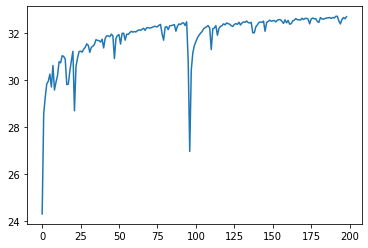

In [18]:
plt.plot(psnr_)

In [19]:
sample_data = test_dataset[41]
print(test_dataset[0].shape)
print(sample_data.shape)

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])


In [20]:
original_x = sample_data
noisy_x = add_noise("poisson",original_x).to(device)
print(noisy_x.shape)

torch.Size([1, 64, 64])


In [21]:
generator.eval()
recovered_x = generator(noisy_x.clip(0,1).reshape([1,1,64,64]))
recovered_x = recovered_x.reshape([1,64,64])
print(recovered_x.shape)

torch.Size([1, 64, 64])


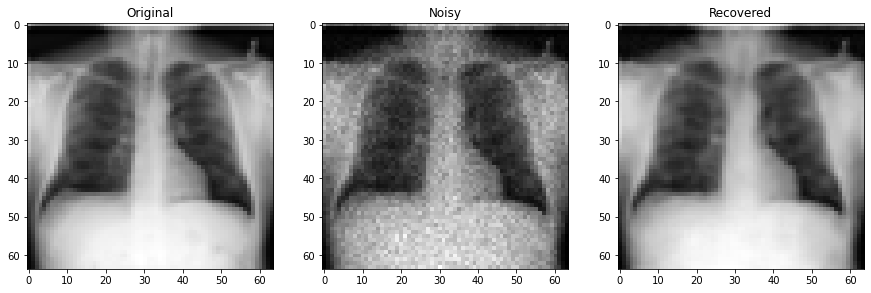

In [22]:
f, a = plt.subplots(1, 3, figsize=(15, 15))

# 시각화를 위해 넘파이 행렬로 바꿔줍니다.
original_img = np.reshape(original_x.to("cpu").data.numpy(), (64, 64))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (64, 64))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (64, 64))

# 원본 사진
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# 오염된 원본 사진
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# 복원된 사진
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()

In [23]:
PSNR(original_img, recovered_img.clip(0,1))

32.8001437924804

In [24]:
original_img.min()

0.0

In [25]:
recovered_img.max()

0.9498832

In [26]:
recovered_img.min()

-0.00340881

In [71]:
import kornia
test_psnr = 0
test_mae = 0
test_mse = 0
test_ssim = 0
mae_loss = nn.L1Loss()
#mse_loss = nn.MSELoss()
i = 0
for x in test_loader :
    i+=1
    generator.eval()
    x_noise = add_noise("gauss",x).clip(0,1)
    fake = generator(x_noise.to(device))
    test_psnr += PSNR(fake.clip(0,1), x.to(device))/len(test_loader)
    #test_mae += mae_loss(fake.clip(0,1), x.to(device))/len(test_loader)
    #test_mse += mse_loss(fake.clip(0,1), x.to(device))/len(test_loader)
    #test_ssim += (kornia.metrics.ssim(fake.clip(0,1), x.to(device), window_size=11).mean())
#test_ssim /= lem(test_loader)        
    
#print('tesr psnr min : ',np.min(test_psnr_list))
print('tesr psnr mean : ',np.mean(test_psnr))
#print('tesr psnr max : ',np.max(test_psnr_list))
#print('tesr mae mean : ',np.mean(test_mae))
#print('tesr mse mean : ',np.mean(test_mse))
#print('tesr ssim mean : ',np.mean(test_ssim))

tesr psnr mean :  29.117531245738316


1

In [59]:
test_mae

0